In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import numpy as np
import os
import pybedtools
from tqdm import tnrange, tqdm_notebook

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass3/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass3/'

# other useful locations

motif_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/UGCAUG_RBFOX2_MOTIF_POSITIONS_ALL.bed'
peak_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/seRBFOX2_A_01.basedon_seRBFOX2_A_01.peaks.l2inputnormnew.bed.compressed.bed'
annotated_peak_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_1/inputs/seRBFOX2_A_01.basedon_seRBFOX2_A_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'
regions_file_for_random_subset = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/hg19_v19_cds_and_three_prime_utrs.bed'

In [3]:
all_windows = sorted(glob.glob(os.path.join(input_dir, 'RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated.windows.txt')))
print(len(all_windows))
all_windows[:3]

1


['/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/pass3/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.annotated.windows.txt']

In [4]:
conf = 0.5

# Read in one of them and check on IGV
- edit_coverage should be the number of reads that were edited throughout the whole window.
- editable_coverage should be the number of reads that cover all edited C's
- edited_over_edited_c should be edit_coverage / editable_coverage
- all_c_coverage should be the coverage across all C's, whether they were found to be edited or not.
- edited_over_all_c should be edit_coverage / all_c_coverage

In [5]:
window = all_windows[0]
df = pd.read_csv(window, sep='\t')
df['region'] = df['name'].apply(lambda x:x.split('|')[1])
df['geneid'] = df['name'].apply(lambda x:x.split('|')[0])
print(df.shape[0])
print(df['region'].value_counts())
df.head(25)

389322
3utr                       248861
CDS                         79510
distintron500               24235
proxintron500               19160
noncoding_exon              10791
5utr                         3504
distnoncoding_intron500      2245
proxnoncoding_intron500       988
miRNA                          26
gene                            2
Name: region, dtype: int64


,chrom,start,end,name,score,strand,edit_coverage,editable_coverage,edited_over_edited_c,all_c_coverage,edited_over_all_c,region,geneid
0,chr1,14488,14537,ENSG00000227232.4|noncoding_exon,0.785678,-,1,25,0.040000,359,0.002786,noncoding_exon,ENSG00000227232.4
1,chr1,17419,17468,ENSG00000227232.4|proxnoncoding_intron500,0.932065,-,1,8,0.125000,131,0.007634,proxnoncoding_intron500,ENSG00000227232.4
2,chr1,18585,18634,ENSG00000227232.4|proxnoncoding_intron500,0.770043,-,1,27,0.037037,280,0.003571,proxnoncoding_intron500,ENSG00000227232.4
3,chr1,18618,18667,ENSG00000227232.4|proxnoncoding_intron500,0.994820,-,2,12,0.166667,167,0.011976,proxnoncoding_intron500,ENSG00000227232.4
4,chr1,20119,20168,ENSG00000227232.4|distnoncoding_intron500,0.989067,-,2,17,0.117647,272,0.007353,distnoncoding_intron500,ENSG00000227232.4
5,chr1,20279,20328,ENSG00000227232.4|distnoncoding_intron500,0.851458,-,1,17,0.058824,295,0.003390,distnoncoding_intron500,ENSG00000227232.4
6,chr1,20327,20376,ENSG00000227232.4|distnoncoding_intron500,0.817907,-,1,21,0.047619,184,0.005435,distnoncoding_intron500,ENSG00000227232.4
7,chr1,20532,20581,ENSG00000227232.4|distnoncoding_intron500,0.801631,-,1,23,0.043478,223,0.004484,distnoncoding_intron500,ENSG00000227232.4
8,chr1,20581,20630,ENSG00000227232.4|distnoncoding_intron500,0.842943,-,1,18,0.055556,185,0.005405,distnoncoding_intron500,ENSG00000227232.4
9,chr1,21294,21343,ENSG00000227232.4|distnoncoding_intron500,0.886385,-,1,13,0.076923,115,0.008696,distnoncoding_intron500,ENSG00000227232.4


# Select 3UTR and CDS only edits

In [6]:
df = df[(df['region']=='CDS') | (df['region']=='3utr')]
df['region'].value_counts()

3utr    248861
CDS      79510
Name: region, dtype: int64

# Remove windows centered around low or 0 confidence sites (either really, really not confident sites or sites that we call "SNPs" (edit_coverage == editable_coverage))

In [7]:
df = df[df['score'] > conf]
print(df.shape[0])

324911


# Remove overlapping windows by choosing the highest "score" (by edited_over_all_c)

In [8]:
score_column = 'edited_over_all_c'

df.sort_values(by=['chrom','start','end','strand'], ascending=True, inplace=True)
dfbt = pybedtools.BedTool.from_dataframe(df[['chrom','start','end','geneid',score_column,'strand']])
dfbt.to_dataframe().head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr1,877779,877828,ENSG00000187634.6,0.010870,+
1,chr1,879267,879316,ENSG00000187634.6,0.011905,+
2,chr1,879629,879678,ENSG00000188976.6,0.040201,-
3,chr1,879635,879684,ENSG00000188976.6,0.048780,-
4,chr1,879637,879686,ENSG00000188976.6,0.048780,-


# bedtools cluster performs a 'merge' but instead of merging, assigns each merged group with an ID (thickStart).
### We can ensure non-overlapping windows by sorting by 'score' (highest to lowest) and removing duplicate cluster IDs, keeping the first one only.  

In [9]:
nonoverlapping = dfbt.cluster().to_dataframe()
nonoverlapping.sort_values(by=['score'], ascending=False, inplace=True)
nonoverlapping.drop_duplicates(['thickStart'], keep='first', inplace=True)
nonoverlapping.sort_values(by=['chrom','start','end','strand'], inplace=True)

# we no longer need the cluster ID, so let's drop the extraneous columns
nonoverlapping = nonoverlapping[['chrom','start','end','name','score','strand']]
nonoverlapping.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr1,877779,877828,ENSG00000187634.6,0.010870,+
1,chr1,879267,879316,ENSG00000187634.6,0.011905,+
4,chr1,879637,879686,ENSG00000188976.6,0.048780,-
11,chr1,879796,879845,ENSG00000188976.6,0.003106,-
14,chr1,879896,879945,ENSG00000188976.6,0.008439,-


# Sanity check - make sure these nonoverlapping windows are actually nonoverlapping.
- just run a simple bedtools merge and make sure they don't overlap.

In [10]:
assert pybedtools.BedTool.from_dataframe(nonoverlapping).sort().merge(s=True, c=(4,5,6), o=('collapse','collapse','distinct')).to_dataframe().shape[0] == nonoverlapping.shape[0]

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


# Now intersect with motifs and see how many intersect.

### Note: Partial overlaps allowed. (if window is at 10-20, report True if motif found at 8-13)

In [11]:
motifs = pybedtools.BedTool(motif_file)
windows = pybedtools.BedTool.from_dataframe(nonoverlapping)

In [12]:
windows_motifs = windows.intersect(motifs, loj=True, s=True).to_dataframe(
    names=[
        'chrom','start','end','geneid','score','strand',
        'motif_chrom','motif_start','motif_end','motif_seq','motif_score','motif_strand'
    ]
)

# drop unused columns.
windows_motifs = windows_motifs[[
    'chrom','start','end','geneid','score','strand','motif_score'
]]

# drop duplicate windows (with more than one motif found)
windows_motifs.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
windows_motifs.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,geneid,score,strand,motif_score
0,chr1,877779,877828,ENSG00000187634.6,0.010870,+,-1
1,chr1,879267,879316,ENSG00000187634.6,0.011905,+,-1
2,chr1,879637,879686,ENSG00000188976.6,0.048780,-,-1
3,chr1,879796,879845,ENSG00000188976.6,0.003106,-,-1
4,chr1,879896,879945,ENSG00000188976.6,0.008439,-,-1


# Optional - (temporarily) filter outliers at the top to get a better sense of the true range of scores.

### Automatically set the number of bins and bin range here too
- basically we just want to set an appropriate range, from 0 - some max score (max score is the highest score, minus the top 0.5%)
- given number of bars that we want to display (n=10), get n evenly divided ranges between 0 and max score. 
- bin each window according to this bin. 
- the top 0.5% edit windows by score will automatically get assigned a bin of 1

In [13]:
def choose_bins(df, n_bins):
    n = int(df.shape[0]*0.005)

    print("Setting the ranges without the top {} values".format(n))
    min_score = 0
    max_score = df.sort_values('score', ascending=False)[n:]['score'].max()

    ticklabels = [round(c, 4) for c in np.arange(min_score, max_score, max_score/n_bins)]
    print(ticklabels)
    return list(np.arange(min_score, max_score, max_score/n_bins)), ticklabels

In [14]:
bins, ticklabels = choose_bins(windows_motifs, n_bins=10)

windows_motifs['bin'] = windows_motifs[['score']].apply(
    lambda x : pd.cut(
        x, 
        ([-1] + bins),
        labels=ticklabels
    )
)
windows_motifs['bin'].fillna(1, inplace=True)
windows_motifs.head()

Setting the ranges without the top 454 values
[0.0, 0.0268, 0.0537, 0.0805, 0.1073, 0.1341, 0.161, 0.1878, 0.2146, 0.2415]


,chrom,start,end,geneid,score,strand,motif_score,bin
0,chr1,877779,877828,ENSG00000187634.6,0.010870,+,-1,0.0268
1,chr1,879267,879316,ENSG00000187634.6,0.011905,+,-1,0.0268
2,chr1,879637,879686,ENSG00000188976.6,0.048780,-,-1,0.0537
3,chr1,879796,879845,ENSG00000188976.6,0.003106,-,-1,0.0268
4,chr1,879896,879945,ENSG00000188976.6,0.008439,-,-1,0.0268


In [15]:
# This shows how many windows we get in each evenly divided bin.
windows_motifs['bin'].value_counts()

0.0268    68462
0.0537    10655
0.0805     4548
0.1073     2563
0.1341     1546
0.1610     1020
0.1878      713
1.0000      650
0.2146      486
0.2415      300
Name: bin, dtype: int64

# Add in some random windows
- use regions_file_for_random_subset which contains only CDS and 3'UTR regions.
- these regions will be appended to the main dataframe with a bin value of -1

In [16]:
x = pybedtools.BedTool.from_dataframe(
    windows_motifs.iloc[:windows_motifs['bin'].value_counts().max()][['chrom','start','end','geneid','score','strand']]
)
random = x.shuffle(genome='hg19', incl=regions_file_for_random_subset)

In [17]:
rand_windows_motifs = random.intersect(motifs, loj=True, s=True).to_dataframe(
    names=[
        'chrom','start','end','geneid','score','strand',
        'motif_chrom','motif_start','motif_end','motif_seq','motif_score','motif_strand'
    ]
)

# drop unused columns.
rand_windows_motifs = rand_windows_motifs[[
    'chrom','start','end','geneid','score','strand','motif_score'
]]
rand_windows_motifs.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
rand_windows_motifs['bin'] = -1
print(rand_windows_motifs.shape[0])
rand_windows_motifs.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


68462


,chrom,start,end,geneid,score,strand,motif_score,bin
0,chr3,158410085,158410134,ENSG00000187634.6,0.010870,+,-1,-1
1,chr3,50155920,50155969,ENSG00000187634.6,0.011905,+,-1,-1
2,chr4,79366942,79366991,ENSG00000188976.6,0.048780,-,-1,-1
3,chr3,13413344,13413393,ENSG00000188976.6,0.003106,-,-1,-1
4,chr10,115884026,115884075,ENSG00000188976.6,0.008439,-,-1,-1


In [18]:
windows_motifs = pd.concat([rand_windows_motifs, windows_motifs])

In [19]:
windows_motifs['bin'].value_counts()

 0.0268    68462
-1.0000    68462
 0.0537    10655
 0.0805     4548
 0.1073     2563
 0.1341     1546
 0.1610     1020
 0.1878      713
 1.0000      650
 0.2146      486
 0.2415      300
Name: bin, dtype: int64

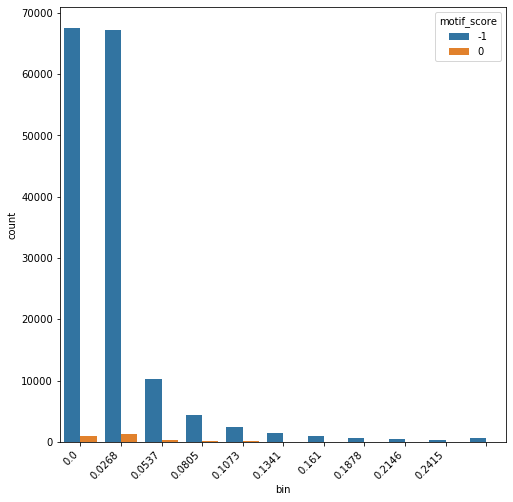

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.countplot(data=windows_motifs, x='bin', hue='motif_score')
ticks = ax.set_xticklabels(ticklabels, rotation = 45, ha="right")

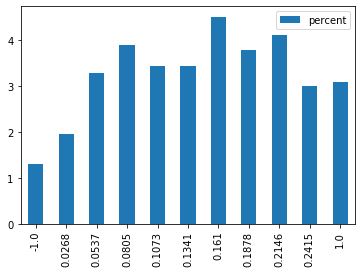

In [21]:
def plot_percent(df, column='overlaps_peak'):
    bin_perc = {}
    for window_bin in set(df['bin']):
        try:
            overlap = df[df['bin']==window_bin][column].value_counts()[0]
        except KeyError:
            overlap = 0
        try:
            nonoverlap = df[df['bin']==window_bin][column].value_counts()[-1]
        except KeyError:
            nonoverlap = 0
        bin_perc[window_bin] = (overlap/(overlap+nonoverlap)*100.)

    pd.DataFrame(bin_perc, index=['percent']).T.sort_index().plot(kind='bar')
    
plot_percent(windows_motifs, column='motif_score')

# Intersect edits with peaks
- Roughly follows the motif intersection methods.

In [22]:
### We may need to filter the peak files prior to BedTool transformation.
peaks = pd.read_csv(peak_file, sep='\t', names=['chrom','start','end','name','score','strand'])
print("Before filtering insignificant peaks: {}".format(peaks.shape[0]))
peaks = peaks[(peaks['name'] >= 3) & (peaks['score'] >= 3)]

# Optional code if we want to 'extend' each peak.
# peaks['start'] = peaks['start'] - 100
# peaks['end'] = peaks['end'] + 100
print("After filtering insignificant peaks: {}".format(peaks.shape[0]))

peaks = pybedtools.BedTool.from_dataframe(peaks)
windows = pybedtools.BedTool.from_dataframe(nonoverlapping)

windows_peaks = windows.intersect(peaks, loj=True, s=True).to_dataframe(
    names=[
        'chrom','start','end','geneid','score','strand',
        'peak_chrom','peak_start','peak_end','peak_seq','peak_score','peak_strand'
    ]
)
# For now we'll just ignore the fold change and just call a score '0' if an edit intersects a peak, '-1' otherwise.
windows_peaks['overlaps_peak'] = windows_peaks['peak_score'].apply(lambda x: 0 if x!=-1 else -1)
# drop unused columns.
windows_peaks = windows_peaks[[
    'chrom','start','end','geneid','score','strand','overlaps_peak'
]]
# drop duplicates in case any edit window contains more than one peak.
windows_peaks.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)

Before filtering insignificant peaks: 42102
After filtering insignificant peaks: 3265


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [23]:
bins, ticklabels = choose_bins(windows_peaks, n_bins=10)

windows_peaks['bin'] = windows_peaks[['score']].apply(
    lambda x : pd.cut(
        x, 
        ([-1] + bins),
        labels=ticklabels
    )
)
windows_peaks['bin'].fillna(1, inplace=True)
windows_peaks['overlaps_peak'].value_counts()

Setting the ranges without the top 454 values
[0.0, 0.0268, 0.0537, 0.0805, 0.1073, 0.1341, 0.161, 0.1878, 0.2146, 0.2415]


-1    90839
 0      104
Name: overlaps_peak, dtype: int64

In [24]:
rand_windows_peaks = random.intersect(peaks, loj=True, s=True).to_dataframe(
    names=[
        'chrom','start','end','geneid','score','strand',
        'peak_chrom','peak_start','peak_end','peak_seq','peak_score','peak_strand'
    ]
)
rand_windows_peaks['overlaps_peak'] = rand_windows_peaks['peak_score'].apply(lambda x: 0 if x!=-1 else -1)
# drop unused columns.
rand_windows_peaks = rand_windows_peaks[[
    'chrom','start','end','geneid','score','strand','overlaps_peak'
]]
rand_windows_peaks.drop_duplicates(subset=['chrom','start','end','geneid','score','strand'], inplace=True)
rand_windows_peaks['bin'] = -1
rand_windows_peaks.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,geneid,score,strand,overlaps_peak,bin
0,chr3,158410085,158410134,ENSG00000187634.6,0.010870,+,-1,-1
1,chr3,50155920,50155969,ENSG00000187634.6,0.011905,+,-1,-1
2,chr4,79366942,79366991,ENSG00000188976.6,0.048780,-,-1,-1
3,chr3,13413344,13413393,ENSG00000188976.6,0.003106,-,-1,-1
4,chr10,115884026,115884075,ENSG00000188976.6,0.008439,-,-1,-1


In [25]:
windows_peaks = pd.concat([rand_windows_peaks, windows_peaks])

In [26]:
x = pybedtools.BedTool()
random = x.random(l=49, n=windows_peaks['bin'].value_counts().max(), genome='hg19')
random_df = random.to_dataframe()
random_df.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,chr10,85803198,85803247,1,49,-
1,chr9,1491156,1491205,2,49,-
2,chr9,51202012,51202061,3,49,+
3,chr11,19547285,19547334,4,49,+
4,chr3,17770709,17770758,5,49,-


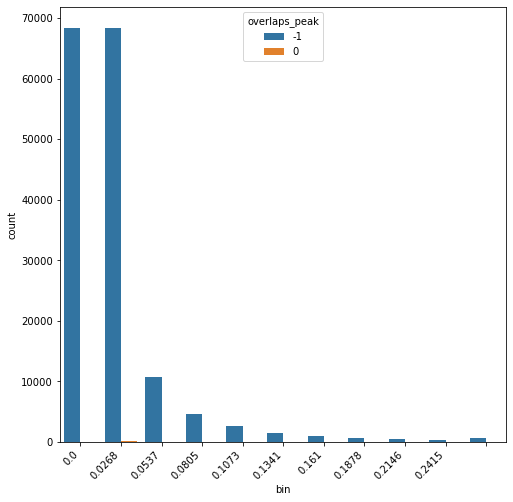

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.countplot(data=windows_peaks, x='bin', hue='overlaps_peak')
ticks = ax.set_xticklabels(ticklabels, rotation = 45, ha="right")

# Intersect with bound genes instead of on a per-peak basis?

In [43]:
### We may need to filter the peak files prior to BedTool transformation.
peaks = pd.read_csv(annotated_peak_file, sep='\t', names=['chrom','start','end','name','score','strand','annotation','geneid'])
print("Before filtering insignificant peaks: {}".format(peaks.shape[0]))
peaks = peaks[(peaks['name'] >= 3) & (peaks['score'] >= 3)]

# Optional code if we want to 'extend' each peak.
# peaks['start'] = peaks['start'] - 100
# peaks['end'] = peaks['end'] + 100
print("After filtering insignificant peaks: {}".format(peaks.shape[0]))

def get_region_from_annotated_eclip_peaks(row):
    try:
        return row['annotation'].split('|')[0]
    except Exception:
        return "intergenic"
    
peaks['region'] = peaks.apply(get_region_from_annotated_eclip_peaks, axis=1)
peaks = peaks[(peaks['region']=='CDS') | (peaks['region']=='3utr')]

def overlaps_gene(row, gene_set=set(peaks['geneid'])):
    if row['name'] in gene_set:
        return 0
    else:
        return -1
    
nonoverlapping['overlaps_bound_gene'] = nonoverlapping.apply(overlaps_gene, axis=1)
nonoverlapping

Before filtering insignificant peaks: 42102
After filtering insignificant peaks: 3265


,chrom,start,end,name,score,strand,overlaps_bound_gene
0,chr1,877779,877828,ENSG00000187634.6,0.010870,+,-1
1,chr1,879267,879316,ENSG00000187634.6,0.011905,+,-1
4,chr1,879637,879686,ENSG00000188976.6,0.048780,-,-1
11,chr1,879796,879845,ENSG00000188976.6,0.003106,-,-1
14,chr1,879896,879945,ENSG00000188976.6,0.008439,-,-1
18,chr1,880055,880104,ENSG00000188976.6,0.007874,-,-1
21,chr1,880428,880477,ENSG00000188976.6,0.005780,-,-1
22,chr1,883542,883591,ENSG00000188976.6,0.002500,-,-1
23,chr1,887377,887426,ENSG00000188976.6,0.001742,-,-1
24,chr1,892468,892517,ENSG00000188976.6,0.002451,-,-1


In [31]:
nonoverlapping

,chrom,start,end,name,score,strand
0,chr1,877779,877828,ENSG00000187634.6,0.010870,+
1,chr1,879267,879316,ENSG00000187634.6,0.011905,+
4,chr1,879637,879686,ENSG00000188976.6,0.048780,-
11,chr1,879796,879845,ENSG00000188976.6,0.003106,-
14,chr1,879896,879945,ENSG00000188976.6,0.008439,-
18,chr1,880055,880104,ENSG00000188976.6,0.007874,-
21,chr1,880428,880477,ENSG00000188976.6,0.005780,-
22,chr1,883542,883591,ENSG00000188976.6,0.002500,-
23,chr1,887377,887426,ENSG00000188976.6,0.001742,-
24,chr1,892468,892517,ENSG00000188976.6,0.002451,-
